In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.sparse.linalg
from scipy.sparse import csc_matrix, csr_matrix, lil_matrix, identity, diags
import scipy.sparse
from scipy.io import mmwrite
from ldpc.codes import rep_code, hamming_code
from bposd.hgp import hgp
from bposd.css import css_code
from ldpc import BpOsdDecoder
from ldpc.bplsd_decoder import BpLsdDecoder
from ldpc.code_util import construct_generator_matrix, compute_code_parameters
from ldpc.mod2 import rank
import networkx as nx
from networkx.algorithms.bipartite import configuration_model, biadjacency_matrix
from multiprocess import Pool
from numba import njit, int8
import greedy_BPOSD, BPOSD_singleshot
from matplotlib import rcParams
rcParams['font.size'] = 14
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = r'\usepackage{amssymb}'

## Basic functions

In [2]:
def f(p,a):
    return 1-(1-p)**a

def df(p,a):
    return a*(1-p)**(a-1)

def get_err(p, N):
    return np.sqrt(p*(1-p)/N)

# 4D toric code

In [3]:
def get_4D_toric_Hx_Hz(L):
    # Create (cyclic) repetition code parity checks
    I_L = np.identity(L, dtype=np.int8)
    H_rep = I_L + np.roll(I_L, 1, axis=1)
    # Create 2D toric code using a hypergraph product
    H_toric2_x = np.concatenate((np.kron(H_rep,I_L), np.kron(I_L,H_rep.T)), axis=1)
    H_toric2_z = np.concatenate((np.kron(I_L,H_rep), np.kron(H_rep.T,I_L)), axis=1)
    # Create 4D toric code using a homological product
    m, n = H_toric2_x.shape
    I_n = np.identity(n, dtype=np.int8)
    I_m = np.identity(m, dtype=np.int8)
    O = np.zeros([2*L**4,L**4], dtype=np.int8)
    row1x = np.concatenate((np.kron(H_toric2_z.T,I_m),np.kron(I_n,H_toric2_z),O), axis=1)
    row2x = np.concatenate((O,np.kron(H_toric2_x,I_n),np.kron(I_m,H_toric2_x.T)), axis=1)
    H_toric4_x = np.concatenate((row1x,row2x), axis=0)
    row1z = np.concatenate((np.kron(I_m,H_toric2_z.T),np.kron(H_toric2_z,I_n),O), axis=1)
    row2z = np.concatenate((O,np.kron(I_n,H_toric2_x),np.kron(H_toric2_x.T,I_m)), axis=1)
    H_toric4_z = np.concatenate((row1z,row2z), axis=0)
    return csr_matrix(H_toric4_x), csr_matrix(H_toric4_z)

def get_4D_toric_Mz(L):
    # Create (cyclic) repetition code parity checks
    I_L = np.identity(L, dtype=np.int8)
    H_rep = I_L + np.roll(I_L, 1, axis=1)
    # Create 2D toric code using a hypergraph product
    H_toric2_x = np.concatenate((np.kron(H_rep,I_L), np.kron(I_L,H_rep.T)), axis=1)
    H_toric2_z = np.concatenate((np.kron(I_L,H_rep), np.kron(H_rep.T,I_L)), axis=1)
    # Create 4D toric code using a homological product
    m, n = H_toric2_x.shape
    I_n = np.identity(n, dtype=np.int8)
    I_m = np.identity(m, dtype=np.int8)
    M_toric_4_z = np.concatenate((np.kron(I_m,H_toric2_x),np.kron(H_toric2_z,I_m)), axis=1)
    return csr_matrix(M_toric_4_z)

In [32]:
L = 4
Hx, Hz = get_4D_toric_Hx_Hz(L)
T4code = css_code(hx=Hx, hz=Hz, name='4D toric')
T4code.D = L**2
T4code.test()

4D toric
 -Block dimensions: Pass
 -PCMs commute hz@hx.T==0: Pass
 -PCMs commute hx@hz.T==0: Pass
 -lx \in ker{hz} AND lz \in ker{hx}: Pass
 -lx and lz anticommute: Pass
 -4D toric is a valid CSS code w/ params [1536,6,16]


True

# Hypergraph product code

In [1091]:
n = 48
d_v = 5
d_c = 6

graph = configuration_model(d_v*np.ones(n,dtype=int), d_c*np.ones(int(n*d_v/d_c),dtype=int), create_using=nx.Graph())
H = biadjacency_matrix(graph, row_order=np.arange(n)).T.toarray()
k, d = compute_code_parameters(H)[1:]
print(n,k,d)

48 8 15


In [1100]:
print(greedy_BPOSD_classical.get_greedy_failures(csr_matrix(H), [100,5], 0.001, 0.001, 50, 500))

21


In [1101]:
HGPcode = hgp(h1=H, h2=H, compute_distance=False)
HGPcode.D = d
HGPcode.test()

<Unnamed CSS code>
 -Block dimensions: Pass
 -PCMs commute hz@hx.T==0: Pass
 -PCMs commute hx@hz.T==0: Pass
 -lx \in ker{hz} AND lz \in ker{hx}: Pass
 -lx and lz anticommute: Pass
 -<Unnamed CSS code> is a valid CSS code w/ params [3904,64,15]


True

# Bivariate code functions

In [38]:
def get_index(i, j, n, m):
    return i*m + j

def get_exps(index, n, m):
    i = index // m
    j = index % m
    return i, j

def get_LR_reps(n, m, l):
    La = lil_matrix((n*m,n*m), dtype=np.int8)
    Lb = lil_matrix((n*m,n*m), dtype=np.int8)
    Ra = lil_matrix((n*m,n*m), dtype=np.int8)
    Rb = lil_matrix((n*m,n*m), dtype=np.int8)
    for index in range(n*m):
        i, j = get_exps(index, n, m)
        index_La = get_index((i+1)%n, j, n, m)
        index_Lb = get_index((l*i)%n, (j+1)%m, n, m)
        index_Ra = get_index((i+pow(l,j,mod=n))%n, j, n, m)
        index_Rb = get_index(i, (j+1)%m, n, m)
        La[index_La, index] = 1
        Lb[index_Lb, index] = 1
        Ra[index_Ra, index] = 1
        Rb[index_Rb, index] = 1
    I = csr_matrix(np.identity(n*m,dtype=np.int8))
    return I, csr_matrix(La), csr_matrix(Lb), csr_matrix(Ra), csr_matrix(Rb)

def find_ells(n, m):
    l_list = []
    for l in range(1,n):
        if pow(l,m,mod=n) == 1:
            l_list.append(l)
    return l_list

# Bivariate Bicycle codes [2308.07915; Table 3]

In [39]:
def get_BB_matrix(a, l, m):
    A = 0
    for i in range(len(a)):
        for j in range(len(a[i])):
            if i==0:
                A += np.kron(np.roll(np.identity(l),a[i][j],axis=1), np.identity(m)).astype(int)
            else:
                A += np.kron(np.identity(l), np.roll(np.identity(m),a[i][j],axis=1)).astype(int)
    return A % 2

def get_BB_Hx_Hz(a, b, l, m):     # a and b are nested lists containing polynomial degrees of x and y
    A = get_BB_matrix(a, l, m)
    B = get_BB_matrix(b, l, m)
    Hx = np.concatenate((A,B),axis=1)
    Hz = np.concatenate((B.T,A.T),axis=1)
    return Hx, Hz

BB144

In [57]:
I,La,Lb,Ra,Rb = get_LR_reps(12,6,1)
degs_A = np.array([[0,11,4],[0,1,5]])
degs_B = np.array([[6,7,8],[0,0,3]])
BBdist = 12

BB360

In [30]:
I,La,Lb,Ra,Rb = get_LR_reps(30,6,1)
degs_A = np.array([[9,3,2],[2,3,5]])
degs_B = np.array([[25,21,18],[0,0,5]])
BBdist = 12

BB756

In [7]:
I,La,Lb,Ra,Rb = get_LR_reps(21,18,1)
degs_A = np.array([[0,20,4],[0,3,6]])
degs_B = np.array([[8,20,0],[9,17,17]])
BBdist = 20

In [58]:
A = La**degs_A[0,0]*Lb**degs_A[1,0] + La**degs_A[0,1]*Lb**degs_A[1,1] + La**degs_A[0,2]*Lb**degs_A[1,2]
B = Rb**degs_B[1,0]*Ra**degs_B[0,0] + Rb**degs_B[1,1]*Ra**degs_B[0,1] + Rb**degs_B[1,2]*Ra**degs_B[0,2]
A = A.toarray()
B = B.toarray()
hx = np.concatenate((A,B), axis=1)
hz = np.concatenate((B.T,A.T), axis=1)
BBcode = css_code(hx=hx, hz=hz, name='BB code')
BBcode.D = BBdist
BBcode.test()

BB code
 -Block dimensions: Pass
 -PCMs commute hz@hx.T==0: Pass
 -PCMs commute hx@hz.T==0: Pass
 -lx \in ker{hz} AND lz \in ker{hx}: Pass
 -lx and lz anticommute: Pass
 -BB code is a valid CSS code w/ params [144,12,12]


True

# ZSZ codes

ZSZ144

In [40]:
I,La,Lb,Ra,Rb = get_LR_reps(12,6,5)
degs_A = np.array([[0,2,8],[1,2,3]])
degs_B = np.array([[4,6,1],[0,4,5]])
ZSZdist = 8

ZSZ288

In [49]:
I,La,Lb,Ra,Rb = get_LR_reps(24,6,5)
degs_A = np.array([[0,14,3],[0,0,3]])
degs_B = np.array([[0,0,8],[0,1,5]])
ZSZdist = 8

ZSZ360

In [75]:
I,La,Lb,Ra,Rb = get_LR_reps(30,6,11)
degs_A = np.array([[12,21,4],[1,4,5]])
degs_B = np.array([[4,20,22],[3,3,4]])
ZSZdist = 20

ZSZ540

In [85]:
I,La,Lb,Ra,Rb = get_LR_reps(45,6,19)
degs_A = np.array([[0,34,4],[0,0,1]])
degs_B = np.array([[0,38,2],[0,0,5]])
ZSZdist = 12

ZSZ756

In [55]:
I,La,Lb,Ra,Rb = get_LR_reps(42,9,25)
degs_A = np.array([[0,4,6],[0,4,3]])
degs_B = np.array([[0,36,21],[0,5,7]])
ZSZdist = 20

In [86]:
A = La**degs_A[0,0]*Lb**degs_A[1,0] + La**degs_A[0,1]*Lb**degs_A[1,1] + La**degs_A[0,2]*Lb**degs_A[1,2]
B = Rb**degs_B[1,0]*Ra**degs_B[0,0] + Rb**degs_B[1,1]*Ra**degs_B[0,1] + Rb**degs_B[1,2]*Ra**degs_B[0,2]
A = A.toarray()
B = B.toarray()
hx = np.concatenate((A,B), axis=1)
hz = np.concatenate((B.T,A.T), axis=1)
ZSZcode = css_code(hx=hx, hz=hz, name='ZSZ code')
ZSZcode.D = ZSZdist
ZSZcode.test()

ZSZ code
 -Block dimensions: Pass
 -PCMs commute hz@hx.T==0: Pass
 -PCMs commute hx@hz.T==0: Pass
 -lx \in ker{hz} AND lz \in ker{hx}: Pass
 -lx and lz anticommute: Pass
 -ZSZ code is a valid CSS code w/ params [540,16,12]


True

### Swap X and Z (CSS dual)

In [17]:
ZSZcode = css_code(hx=hz, hz=hx, name='ZSZ code')
ZSZcode.D = ZSZdist
ZSZcode.test()

ZSZ code
 -Block dimensions: Pass
 -PCMs commute hz@hx.T==0: Pass
 -PCMs commute hx@hz.T==0: Pass
 -lx \in ker{hz} AND lz \in ker{hx}: Pass
 -lx and lz anticommute: Pass
 -ZSZ code is a valid CSS code w/ params [756,24,20]


True

# Greedy decoding simulation (final BP+LSD)

In [18]:
res = 10
p_min = 1E-5
p_max = 1E-4
p_list = np.logspace(np.log10(p_min), np.log10(p_max), res)
print(p_list)

[1.00000000e-05 1.29154967e-05 1.66810054e-05 2.15443469e-05
 2.78255940e-05 3.59381366e-05 4.64158883e-05 5.99484250e-05
 7.74263683e-05 1.00000000e-04]


In [19]:
p_list = np.load('Data/p_list_greedy.npy')
res = len(p_list)

In [29]:
sim_code = ZSZcode
iters = np.logspace(5.5, 2, res, dtype=int)
cycles = 100
circuit_seed = 0

THREADS = 8    # Number of parallel threads
pool = Pool(processes=THREADS)

for r in range(3,4):
    print('Progress: {} / {}        '.format(r+1,res), end='\r')
    noise_pars = [p_list[r]/10, p_list[r], p_list[r], p_list[r]]     # [p1, p2, p_spam, p_dec]
    params = (sim_code, [1000,5], noise_pars, cycles, 1, iters[r]//THREADS, circuit_seed)
    args = [params for j in range(THREADS)]
    if __name__ ==  '__main__':
        failures = pool.starmap(greedy_BPOSD.get_greedy_failures, args)
        LERs = [np.sum(failures), iters[r]//THREADS*THREADS]
    if LERs[0] == LERs[1]:    # If all previous runs failed, terminate simulation
        break

    # LERs_saved = np.load('Data/T4_L=5_LERs_greedy.npy'.format(sim_code.N))
    # LERs_saved[r] += LERs
    # np.save('Data/T4_L=5_LERs_greedy.npy'.format(sim_code.N), LERs_saved)
    
pool.close()

Progress: 4 / 10        

In [30]:
print(LERs)

[43, 21544]


In [50]:
np.save('Data/p_list_greedy', p_list)

In [24]:
# np.save('Data/ZSZ360_LERs_greedy', np.zeros([res,2],dtype=int))

In [20]:
print(np.load('Data/ZSZ756_LERs_greedy.npy'))

[[    11 300000]
 [    17  92816]
 [    23  43088]
 [    44  20000]
 [    29   4640]
 [    53   2152]
 [    88   1000]
 [   155    464]
 [   140    208]
 [    95     96]]


## Plot simulation results

C:\Users\honyi\AppData\Local\Temp\ipykernel_10256\4178942789.py:41: RuntimeWarning: invalid value encountered in divide
  p = T4data[i][:,0]/T4data[i][:,1]


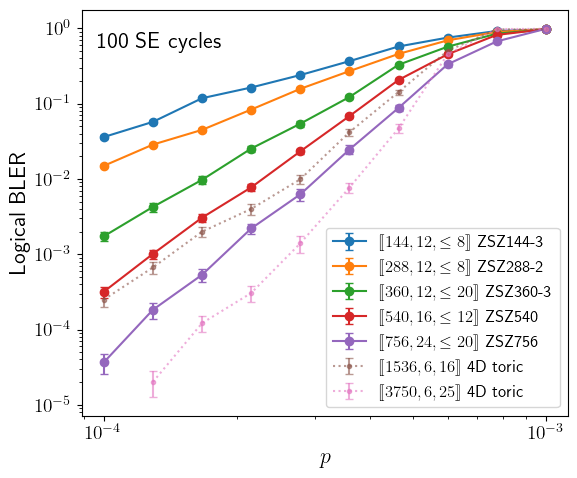

In [44]:
p_list = np.load('Data/p_list_greedy.npy')

ZSZdata = []
ZSZdata.append(np.load('Data/ZSZ144_LERs_greedy.npy'))
ZSZdata.append(np.load('Data/ZSZ288_LERs_greedy.npy'))
ZSZdata.append(np.load('Data/ZSZ360_LERs_greedy.npy'))
ZSZdata.append(np.load('Data/ZSZ540_LERs_greedy.npy'))
ZSZdata.append(np.load('Data/ZSZ756_LERs_greedy.npy'))

BBdata = []
BBdata.append(np.load('Data/BB144_LERs_greedy.npy'))
BBdata.append(np.load('Data/BB360_LERs_greedy.npy'))
BBdata.append(np.load('Data/BB756_LERs_greedy.npy'))

T4data = []
T4data.append(np.load('Data/T4_L=4_LERs_greedy.npy'))
T4data.append(np.load('Data/T4_L=5_LERs_greedy.npy'))

HGPdata = np.load('Data/HGP3904_LERs_greedy.npy')
p = HGPdata[:,0] / HGPdata[:,1]
HGP_LERs = p
HGP_LERs_std = np.sqrt(p*(1-p)/HGPdata[:,1])

ZSZ_LERs = []
ZSZ_LERs_std = []
for i in range(len(ZSZdata)):
    p = ZSZdata[i][:,0]/ZSZdata[i][:,1]
    ZSZ_LERs.append(p)
    ZSZ_LERs_std.append(np.sqrt(p*(1-p)/ZSZdata[i][:,1]))

BB_LERs = []
BB_LERs_std = []
for i in range(len(BBdata)):
    p = BBdata[i][:,0]/BBdata[i][:,1]
    BB_LERs.append(p)
    BB_LERs_std.append(np.sqrt(p*(1-p)/BBdata[i][:,1]))

T4_LERs = []
T4_LERs_std = []
for i in range(len(T4data)):
    p = T4data[i][:,0]/T4data[i][:,1]
    T4_LERs.append(p)
    T4_LERs_std.append(np.sqrt(p*(1-p)/T4data[i][:,1]))

plt.figure(figsize=[6,5])

ZSZ_labels = ['$[\![144,12,\leq8]\!]$ ZSZ144-3', '$[\![288,12,\leq8]\!]$ ZSZ288-2', '$[\![360,12,\leq20]\!]$ ZSZ360-3',
        '$[\![540,16,\leq12]\!]$ ZSZ540', '$[\![756,24,\leq20]\!]$ ZSZ756']
for i in range(len(ZSZ_LERs)):
    plt.errorbar(p_list, ZSZ_LERs[i], yerr=ZSZ_LERs_std[i], fmt='o-', capsize=3, label=ZSZ_labels[i])

# BB_labels = ['$[\![144,12,\leq12]\!]$ BB144-2', '$[\![360,12,\leq12]\!]$ BB360-2', '$[\![756,16,\leq20]\!]$ BB756-1']
# for i in range(len(BB_LERs)):
#     plt.errorbar(p_list, BB_LERs[i], yerr=BB_LERs_std[i], fmt='o-', capsize=3, alpha=1, label=BB_labels[i])

T4scale = 1
T4_labels = ['$[\![1536,6,16]\!]$ 4D toric', '$[\![3750,6,25]\!]$ 4D toric']
for i in range(len(T4_LERs)):
    plt.errorbar(p_list, f(T4_LERs[i],T4scale), yerr=df(T4_LERs[i],T4scale)*T4_LERs_std[i], fmt='.:', capsize=3, alpha=0.6, label=T4_labels[i])

# plt.errorbar(p_list, HGP_LERs, yerr=HGP_LERs_std, fmt='^--', capsize=1, alpha=0.6, label='$[\![3904,64,15]\!]$ HGP ($p/10$)')
    
plt.xlabel('$p$', fontsize=16)
plt.ylabel(r'Logical BLER', fontsize=16)
# plt.title('100 rounds greedy, $p_1=p/10$, $p_2=p_{\mathrm{spam}}=p$')
plt.yscale('log')
plt.xscale('log')
plt.figtext(0.18, 0.88, '100 SE cycles', size=16)
plt.legend(fontsize=12)
plt.tight_layout()
# plt.savefig('Plots/ZSZ_vs_T4_greedy.pdf')

# Probe asymptotics as cycles $\rightarrow\infty$

In [6]:
res = 10
cycles_list = np.logspace(1,2.5,res, dtype=int)
print(cycles_list)

[ 10  14  21  31  46  68 100 146 215 316]


In [ ]:
sim_code = T4code
p = 3E-4
iters = 100000
circuit_seed = 0

THREADS = 8    # Number of parallel threads
pool = Pool(processes=THREADS)

for r in range(0,6):
    print('Progress: {} / {}        '.format(r+1,res), end='\r')
    noise_pars = [p/10, p, p, p]     # [p1, p2, p_spam, p_dec]
    params = (sim_code, [1000,5], noise_pars, cycles_list[r], 1, iters//THREADS, circuit_seed)
    args = [params for j in range(THREADS)]
    if __name__ ==  '__main__':
        failures = pool.starmap(greedy_BPOSD.get_greedy_failures, args)
        LERs = [np.sum(failures), iters//THREADS*THREADS]
    if LERs[0] == LERs[1]:    # If all previous runs failed, terminate simulation
        break

    LERs_saved = np.load('Data/T4_L=5_LERs_greedy_cycles.npy'.format(sim_code.N))
    LERs_saved[r] += LERs
    np.save('Data/T4_L=5_LERs_greedy_cycles.npy'.format(sim_code.N), LERs_saved)
    
pool.close()

Progress: 1 / 10        

In [16]:
np.save('Data/cycles_list', cycles_list)

In [7]:
np.save('Data/T4_L=5_LERs_greedy_cycles', np.zeros([res,2],dtype=int))

In [19]:
print(np.load('Data/T4_L=5_LERs_greedy_cycles.npy'))

[[     7 300000]
 [    11 300000]
 [    46 300000]
 [    66 200000]
 [   132 200000]
 [   200 200000]
 [   165 100000]
 [   273 100000]
 [   406 100000]
 [   617 100000]]


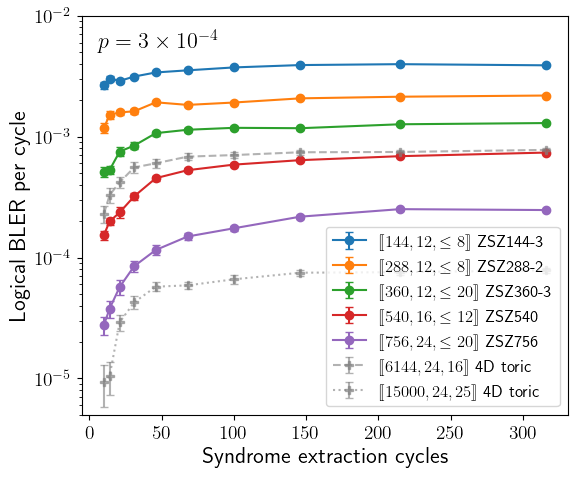

In [20]:
cycles_list = np.load('Data/cycles_list.npy')

T4data = []
T4data.append(np.load('Data/T4_L=4_LERs_greedy_cycles.npy'))
T4data.append(np.load('Data/T4_L=5_LERs_greedy_cycles.npy'))

BBdata = []
BBdata.append(np.load('Data/BB144_LERs_greedy_cycles.npy'))
BBdata.append(np.load('Data/BB360_LERs_greedy_cycles.npy'))
BBdata.append(np.load('Data/BB756_LERs_greedy_cycles.npy'))

ZSZdata = []
ZSZdata.append(np.load('Data/ZSZ144_LERs_greedy_cycles.npy'))
ZSZdata.append(np.load('Data/ZSZ288_LERs_greedy_cycles.npy'))
ZSZdata.append(np.load('Data/ZSZ360_LERs_greedy_cycles.npy'))
ZSZdata.append(np.load('Data/ZSZ540_LERs_greedy_cycles.npy'))
ZSZdata.append(np.load('Data/ZSZ756_LERs_greedy_cycles.npy'))

ZSZ_LERs = []
ZSZ_LERs_std = []
for i in range(len(ZSZdata)):
    p = ZSZdata[i][:,0]/ZSZdata[i][:,1]
    ZSZ_LERs.append(p)
    ZSZ_LERs_std.append(np.sqrt(p*(1-p)/ZSZdata[i][:,1]))

BB_LERs = []
BB_LERs_std = []
for i in range(len(BBdata)):
    p = BBdata[i][:,0]/BBdata[i][:,1]
    BB_LERs.append(p)
    BB_LERs_std.append(np.sqrt(p*(1-p)/BBdata[i][:,1]))

T4_LERs = []
T4_LERs_std = []
for i in range(len(T4data)):
    p = T4data[i][:,0]/T4data[i][:,1]
    T4_LERs.append(p)
    T4_LERs_std.append(np.sqrt(p*(1-p)/T4data[i][:,1]))

plt.figure(figsize=[6,5])
    
ZSZ_labels = ['$[\![144,12,\leq8]\!]$ ZSZ144-3', '$[\![288,12,\leq8]\!]$ ZSZ288-2', '$[\![360,12,\leq20]\!]$ ZSZ360-3', 
              '$[\![540,16,\leq12]\!]$ ZSZ540', '$[\![756,24,\leq20]\!]$ ZSZ756']
for i in range(len(ZSZ_LERs)):
    plt.errorbar(cycles_list, f(ZSZ_LERs[i],1/cycles_list), yerr=df(ZSZ_LERs[i],1/cycles_list)*ZSZ_LERs_std[i], 
                 fmt='o-', capsize=3, label=ZSZ_labels[i])

# BB_labels = ['$[\![144,12,\leq12]\!]$ BB144-3', '$[\![360,12,\leq12]\!]$ BB360-2', '$[\![756,16,\leq20]\!]$ BB756-1']
# for i in range(len(BB_LERs)):
#     plt.errorbar(cycles_list, f(BB_LERs[i],1/cycles_list), yerr=df(BB_LERs[i],1/cycles_list)*BB_LERs_std[i], 
#                  fmt='o-', capsize=3, label=BB_labels[i])

T4scale = 4
T4_labels = ['$[\![6144,24,16]\!]$ 4D toric', '$[\![15000,24,25]\!]$ 4D toric']
T4_fmts = ['P--', 'P:']
for i in range(len(T4_LERs)):
    plt.errorbar(cycles_list, f(T4_LERs[i],T4scale/cycles_list), yerr=df(T4_LERs[i],T4scale/cycles_list)*T4_LERs_std[i], 
                 fmt=T4_fmts[i], color='gray', alpha=0.6, capsize=3, label=T4_labels[i])
    
# plt.title(r'Noisy greedy decoding, $p=3\times 10^{-4}$')
plt.xlabel('Syndrome extraction cycles', fontsize=16)
plt.ylabel(r'Logical BLER per cycle', fontsize=16)
plt.yscale('log')
# plt.xscale('log')
# plt.xlim([0.9E-4, 2.2E-3])
plt.ylim([5E-6, 1E-2])
plt.legend(fontsize=12, loc='lower right')
plt.figtext(0.18, 0.88, r'$p=3\times 10^{-4}$', size=16)
plt.tight_layout()
# plt.savefig('Plots/BB_greedy_cycles.pdf')

# Estimate ZSZ passive threshold

In [51]:
res = 8
p_min = 7E-4
p_max = 1E-3
p_list = np.logspace(np.log10(p_min), np.log10(p_max), res)
print(p_list)

[0.0007     0.00073659 0.0007751  0.00081561 0.00085825 0.00090311
 0.00095032 0.001     ]


In [124]:
p_list = np.load('Data/p_list_greedy_th.npy')
res = len(p_list)
print(p_list)

[0.0007     0.00073659 0.0007751  0.00081561 0.00085825 0.00090311
 0.00095032 0.001     ]


In [129]:
sim_code = ZSZcode
iters = np.logspace(4, 3, res, dtype=int)
cycles = 100
circuit_seed = 0

THREADS = 8    # Number of parallel threads
pool = Pool(processes=THREADS)

for r in range(0,res):
    print('Progress: {} / {}        '.format(r+1,res), end='\r')
    noise_pars = [p_list[r]/10, p_list[r], p_list[r], p_list[r]]     # [p1, p2, p_spam, p_dec]
    params = (sim_code, [1000,5], noise_pars, cycles, 1, iters[r]//THREADS, circuit_seed)
    args = [params for j in range(THREADS)]
    if __name__ ==  '__main__':
        failures = pool.starmap(greedy_BPOSD.get_greedy_failures, args)
        LERs = [np.sum(failures), iters[r]//THREADS*THREADS]
    if LERs[0] == LERs[1]:    # If all previous runs failed, terminate simulation
        break

    LERs_saved = np.load('Data/ZSZ{}_th_LERs_greedy.npy'.format(sim_code.N))
    LERs_saved[r] += LERs
    np.save('Data/ZSZ{}_th_LERs_greedy.npy'.format(sim_code.N), LERs_saved)
    
pool.close()

Progress: 8 / 8        

In [52]:
np.save('Data/p_list_greedy_th', p_list)

In [93]:
# np.save('Data/ZSZ756_th_LERs_greedy', np.zeros([res,2],dtype=int))

In [126]:
print(np.load('Data/ZSZ756_th_LERs_greedy.npy'))

[[ 5871 11000]
 [ 5037  8192]
 [ 4399  6176]
 [ 3696  4720]
 [ 3187  3680]
 [ 2647  2928]
 [ 2290  2384]
 [ 1966  2000]]


## Plot ZSZ threshold

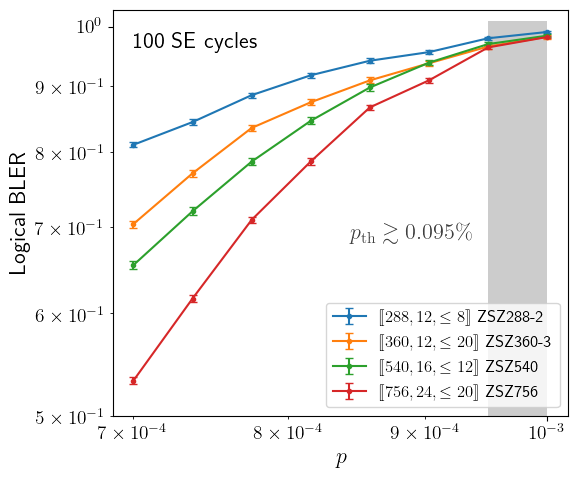

In [7]:
p_list = np.load('Data/p_list_greedy_th.npy')

ZSZdata = []
ZSZdata.append(np.load('Data/ZSZ288_th_LERs_greedy.npy'))
ZSZdata.append(np.load('Data/ZSZ360_th_LERs_greedy.npy'))
ZSZdata.append(np.load('Data/ZSZ540_th_LERs_greedy.npy'))
ZSZdata.append(np.load('Data/ZSZ756_th_LERs_greedy.npy'))

ZSZ_LERs = []
ZSZ_LERs_std = []
for i in range(len(ZSZdata)):
    p = ZSZdata[i][:,0]/ZSZdata[i][:,1]
    ZSZ_LERs.append(p)
    ZSZ_LERs_std.append(np.sqrt(p*(1-p)/ZSZdata[i][:,1]))

fig, ax = plt.subplots(1, figsize=[6,5])

rect = patches.Rectangle([9.5E-4,5E-1], 0.5E-4, 5.1E-1, facecolor='gray', alpha=0.4)
ax.add_patch(rect)
plt.figtext(0.6, 0.5, r'$p_\mathrm{th} \gtrsim 0.095\%$', size=16, alpha=0.75)

ZSZ_labels = ['$[\![288,12,\leq8]\!]$ ZSZ288-2', '$[\![360,12,\leq20]\!]$ ZSZ360-3', '$[\![540,16,\leq12]\!]$ ZSZ540',
              '$[\![756,24,\leq20]\!]$ ZSZ756']
for i in range(len(ZSZ_LERs)):
    plt.errorbar(p_list, ZSZ_LERs[i], yerr=ZSZ_LERs_std[i], fmt='.-', capsize=3, alpha=1, label=ZSZ_labels[i])

plt.xlabel('$p$', fontsize=16)
plt.ylabel(r'Logical BLER', fontsize=16)
# plt.title('100 rounds greedy, $p_1=p/10$, $p_2=p_{\mathrm{spam}}=p$')
plt.yscale('log')
plt.xscale('log')
plt.ylim([5E-1,1.03])
plt.figtext(0.24, 0.88, '100 SE cycles', size=16)
plt.legend(fontsize=12, loc='lower right')
plt.tight_layout()
# plt.savefig('Plots/ZSZ_th_greedy.pdf')

# Estimate 4D toric passive threshold

In [16]:
L = 6
Hx, Hz = get_4D_toric_Hx_Hz(L)
T4code = css_code(hx=Hx, hz=Hz, name='4D toric')
T4code.D = L**2
T4code.test()

4D toric
 -Block dimensions: Pass
 -PCMs commute hz@hx.T==0: Pass
 -PCMs commute hx@hz.T==0: Pass
 -lx \in ker{hz} AND lz \in ker{hx}: Pass
 -lx and lz anticommute: Pass
 -4D toric is a valid CSS code w/ params [7776,6,36]


True

In [149]:
res = 8
p_min = 5E-4
p_max = 8E-4
p_list = np.logspace(np.log10(p_min), np.log10(p_max), res)
print(p_list)

[0.0005     0.00053472 0.00057186 0.00061158 0.00065405 0.00069947
 0.00074805 0.0008    ]


In [10]:
p_list = np.load('Data/p_list_greedy_T4_th.npy')
res = len(p_list)
print(p_list)

[0.0005     0.00053472 0.00057186 0.00061158 0.00065405 0.00069947
 0.00074805 0.0008    ]


In [12]:
sim_code = T4code
iters = np.logspace(3.5, 3, res, dtype=int)
cycles = 100
circuit_seed = 0

THREADS = 8    # Number of parallel threads
pool = Pool(processes=THREADS)

for r in range(0,res):
    print('Progress: {} / {}        '.format(r+1,res), end='\r')
    noise_pars = [p_list[r]/10, p_list[r], p_list[r], p_list[r]]     # [p1, p2, p_spam, p_dec]
    params = (sim_code, [1000,5], noise_pars, cycles, 1, iters[r]//THREADS, circuit_seed)
    args = [params for j in range(THREADS)]
    if __name__ ==  '__main__':
        failures = pool.starmap(greedy_BPOSD.get_greedy_failures, args)
        LERs = [np.sum(failures), iters[r]//THREADS*THREADS]
    if LERs[0] == LERs[1]:    # If all previous runs failed, terminate simulation
        break

    LERs_saved = np.load('Data/T4_th_L={}_LERs_greedy.npy'.format(L))
    LERs_saved[r] += LERs
    np.save('Data/T4_th_L={}_LERs_greedy.npy'.format(L), LERs_saved)
    
pool.close()

Progress: 8 / 8        

In [150]:
np.save('Data/p_list_greedy_T4_th', p_list)

In [153]:
np.save('Data/T4_th_L=6_LERs_greedy', np.zeros([res,2],dtype=int))

In [13]:
print(np.load('Data/T4_th_L=5_LERs_greedy.npy'))

[[ 332 3160]
 [ 475 2680]
 [ 752 2272]
 [1008 1928]
 [1226 1632]
 [1261 1384]
 [1146 1176]
 [ 981 1000]]


## Plot 4D toric threshold

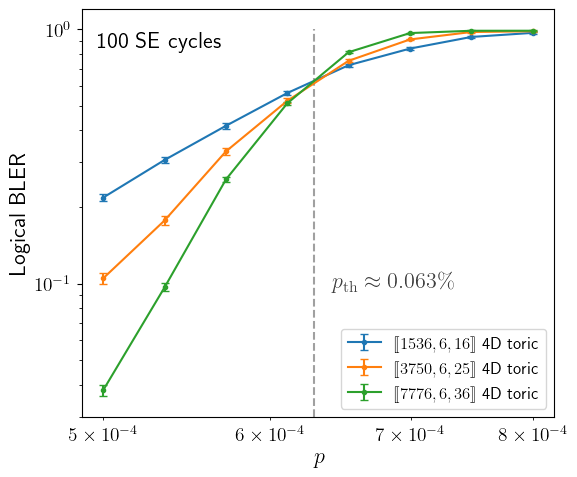

In [9]:
p_list = np.load('Data/p_list_greedy_T4_th.npy')

T4data = []
T4data.append(np.load('Data/T4_th_L=4_LERs_greedy.npy'))
T4data.append(np.load('Data/T4_th_L=5_LERs_greedy.npy'))
T4data.append(np.load('Data/T4_th_L=6_LERs_greedy.npy'))

T4_LERs = []
T4_LERs_std = []
for i in range(len(T4data)):
    p = T4data[i][:,0]/T4data[i][:,1]
    T4_LERs.append(p)
    T4_LERs_std.append(np.sqrt(p*(1-p)/T4data[i][:,1]))

plt.figure(figsize=[6,5])

T4_labels = ['$[\![1536,6,16]\!]$ 4D toric', '$[\![3750,6,25]\!]$ 4D toric', '$[\![7776,6,36]\!]$ 4D toric']
for i in range(len(T4_LERs)):
    plt.errorbar(p_list, T4_LERs[i], yerr=T4_LERs_std[i], fmt='.-', capsize=3, alpha=1, label=T4_labels[i])

x = 6.3E-4
plt.plot([x,x], [3E-2,1], color='gray', linestyle='dashed', alpha=0.75)
plt.figtext(0.57, 0.4, r'$p_\mathrm{th} \approx 0.063\%$', size=16, alpha=0.75)

plt.xlabel('$p$', fontsize=16)
plt.ylabel(r'Logical BLER', fontsize=16)
# plt.title('100 rounds greedy, $p_1=p/10$, $p_2=p_{\mathrm{spam}}=p$')
plt.yscale('log')
plt.xscale('log')
plt.ylim([3E-2,1.2])
plt.figtext(0.18, 0.88, '100 SE cycles', size=16)
plt.legend(fontsize=12, loc='lower right')
plt.tight_layout()
# plt.savefig('Plots/T4_th_greedy.pdf')

# Classical feedback with many sweeps

In [34]:
res = 10
p_min = 1.3E-3
p_max = 1.9E-3
p_list = np.linspace(p_min, p_max, res)
print(p_list)

[0.0013     0.00136667 0.00143333 0.0015     0.00156667 0.00163333
 0.0017     0.00176667 0.00183333 0.0019    ]


In [44]:
p_list = np.load('Data/p_list_greedy_sweeps=20.npy')
res = len(p_list)
print(p_list)

[0.0013     0.00136667 0.00143333 0.0015     0.00156667 0.00163333
 0.0017     0.00176667 0.00183333 0.0019    ]


In [87]:
sim_code = ZSZcode
iters = np.logspace(4, 3, res, dtype=int)
cycles = 100
sweeps = 20
circuit_seed = 0

THREADS = 8    # Number of parallel threads
pool = Pool(processes=THREADS)

for r in range(0,res):
    print('Progress: {} / {}        '.format(r+1,res), end='\r')
    noise_pars = [p_list[r]/10, p_list[r], p_list[r], 0]     # [p1, p2, p_spam, p_dec]
    params = (sim_code, [1000,5], noise_pars, cycles, sweeps, iters[r]//THREADS, circuit_seed)
    args = [params for j in range(THREADS)]
    if __name__ ==  '__main__':
        failures = pool.starmap(greedy_BPOSD.get_greedy_failures, args)
        LERs = [np.sum(failures), iters[r]//THREADS*THREADS]

    LERs_saved = np.load('Data/ZSZ{}_LERs_greedy_sweeps={}.npy'.format(sim_code.N, sweeps))
    LERs_saved[r] += LERs
    np.save('Data/ZSZ{}_LERs_greedy_sweeps={}.npy'.format(sim_code.N, sweeps), LERs_saved)
    
    if LERs[0] == LERs[1]:    # If all previous runs failed, terminate simulation
        break
    
pool.close()

Progress: 9 / 10        

In [46]:
print(LERs)

[9680, 10000]


In [35]:
np.save('Data/p_list_greedy_sweeps=20', p_list)

In [78]:
np.save('Data/ZSZ360_LERs_greedy_sweeps=20', np.zeros([res,2],dtype=int))

In [88]:
print(np.load('Data/ZSZ540_LERs_greedy_sweeps=20.npy'))

[[18150 20000]
 [14493 15472]
 [11625 11984]
 [ 9093  9280]
 [ 7124  7184]
 [ 5525  5552]
 [ 4293  4304]
 [ 3326  3328]
 [ 1289  1289]
 [    1     1]]


In [73]:
LERs_saved = np.load('Data/ZSZ540_LERs_greedy_sweeps=20.npy')
LERs_saved[-1] = [1,1]
np.save('Data/ZSZ540_LERs_greedy_sweeps=20', LERs_saved)

## Plot ZSZ single-shot threshold

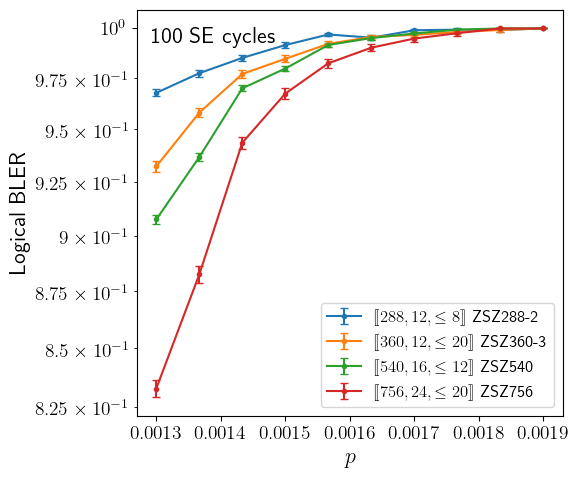

In [93]:
p_list = np.load('Data/p_list_greedy_sweeps=20.npy')

ZSZdata = []
ZSZdata.append(np.load('Data/ZSZ288_LERs_greedy_sweeps=20.npy'))
ZSZdata.append(np.load('Data/ZSZ360_LERs_greedy_sweeps=20.npy'))
ZSZdata.append(np.load('Data/ZSZ540_LERs_greedy_sweeps=20.npy'))
ZSZdata.append(np.load('Data/ZSZ756_LERs_greedy_sweeps=20.npy'))

ZSZ_LERs = []
ZSZ_LERs_std = []
for i in range(len(ZSZdata)):
    p = ZSZdata[i][:,0]/ZSZdata[i][:,1]
    ZSZ_LERs.append(p)
    ZSZ_LERs_std.append(np.sqrt(p*(1-p)/ZSZdata[i][:,1]))

fig, ax = plt.subplots(1, figsize=[6,5])

# rect = patches.Rectangle([9.5E-4,5E-1], 0.5E-4, 5.1E-1, facecolor='gray', alpha=0.4)
# ax.add_patch(rect)
# plt.figtext(0.6, 0.5, r'$p_\mathrm{th} \gtrsim 0.095\%$', size=16, alpha=0.75)

ZSZ_labels = ['$[\![288,12,\leq8]\!]$ ZSZ288-2', '$[\![360,12,\leq20]\!]$ ZSZ360-3', '$[\![540,16,\leq12]\!]$ ZSZ540',
              '$[\![756,24,\leq20]\!]$ ZSZ756']
for i in range(len(ZSZ_LERs)):
    plt.errorbar(p_list, ZSZ_LERs[i], yerr=ZSZ_LERs_std[i], fmt='.-', capsize=3, alpha=1, label=ZSZ_labels[i])

plt.xlabel('$p$', fontsize=16)
plt.ylabel(r'Logical BLER', fontsize=16)
# plt.title('100 rounds greedy, $p_1=p/10$, $p_2=p_{\mathrm{spam}}=p$')
plt.yscale('log')
# plt.xscale('log')
# plt.xlim([8E-4,2.05E-3])
# plt.ylim([2.8E-4,1.05])
plt.figtext(0.27, 0.89, '100 SE cycles', size=16)
plt.legend(fontsize=12, loc='lower right')
plt.tight_layout()
# plt.savefig('Plots/ZSZ_greedy_singleshot.pdf')

# 4D toric single-shot simulation

In [4]:
L = 3
Hx, Hz = get_4D_toric_Hx_Hz(L)
Mz = get_4D_toric_Mz(L)
T4code = css_code(hx=Hx, hz=Hz, name='4D toric')
T4code.D = L**2
T4code.test()

4D toric
 -Block dimensions: Pass
 -PCMs commute hz@hx.T==0: Pass
 -PCMs commute hx@hz.T==0: Pass
 -lx \in ker{hz} AND lz \in ker{hx}: Pass
 -lx and lz anticommute: Pass
 -4D toric is a valid CSS code w/ params [486,6,9]


True

In [108]:
res = 10
p_min = 1E-3
p_max = 4E-3
p_list = np.logspace(np.log10(p_min), np.log10(p_max), res)
print(p_list)

[0.001      0.00116653 0.00136079 0.0015874  0.00185175 0.00216012
 0.00251984 0.00293947 0.00342898 0.004     ]


In [5]:
p_list = np.load('Data/p_list_T4_singleshot.npy')
res = len(p_list)
print(p_list)

[0.001      0.00116653 0.00136079 0.0015874  0.00185175 0.00216012
 0.00251984 0.00293947 0.00342898 0.004     ]


In [ ]:
sim_code = T4code
iters = np.logspace(3, 2, res, dtype=int)
cycles = 100
circuit_seed = 0

THREADS = 8    # Number of parallel threads
pool = Pool(processes=THREADS)

for r in range(0,res):
    print('Progress: {} / {}        '.format(r+1,res), end='\r')
    noise_pars = [p_list[r]/10, p_list[r], p_list[r]]     # [p1, p2, p_spam]
    params = (sim_code, Mz, [1000,5], noise_pars, cycles, iters[r]//THREADS, circuit_seed)
    args = [params for j in range(THREADS)]
    if __name__ ==  '__main__':
        failures = pool.starmap(BPOSD_singleshot.get_BPOSD_failures, args)
        LERs = [np.sum(failures), iters[r]//THREADS*THREADS]
    if LERs[0] == LERs[1]:    # If all previous runs failed, terminate simulation
        break

    LERs_saved = np.load('Data/T4_L={}_LERs_singleshot.npy'.format(L))
    LERs_saved[r] += LERs
    np.save('Data/T4_L={}_LERs_singleshot.npy'.format(L), LERs_saved)
    
pool.close()

Progress: 1 / 10        

In [109]:
np.save('Data/p_list_T4_singleshot', p_list)

In [110]:
np.save('Data/T4_L=3_LERs_singleshot', np.zeros([res,2],dtype=int))

In [111]:
print(np.load('Data/T4_L=3_LERs_singleshot.npy'))

[[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]


## Plot 4D toric single-shot threshold

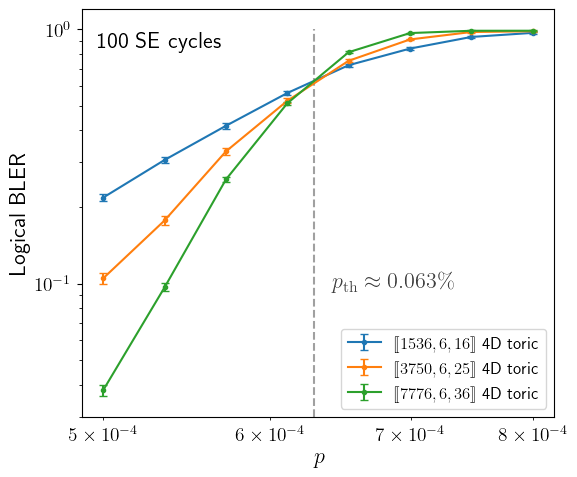

In [9]:
p_list = np.load('Data/p_list_T4_singleshot.npy')

T4data = []
T4data.append(np.load('Data/T4_L=3_LERs_singleshot.npy'))
T4data.append(np.load('Data/T4_L=4_LERs_singleshot.npy'))
T4data.append(np.load('Data/T4_L=5_LERs_singleshot.npy'))

T4_LERs = []
T4_LERs_std = []
for i in range(len(T4data)):
    p = T4data[i][:,0]/T4data[i][:,1]
    T4_LERs.append(p)
    T4_LERs_std.append(np.sqrt(p*(1-p)/T4data[i][:,1]))

plt.figure(figsize=[6,5])

T4_labels = ['$[\![1536,6,16]\!]$ 4D toric', '$[\![3750,6,25]\!]$ 4D toric', '$[\![7776,6,36]\!]$ 4D toric']
for i in range(len(T4_LERs)):
    plt.errorbar(p_list, T4_LERs[i], yerr=T4_LERs_std[i], fmt='.-', capsize=3, alpha=1, label=T4_labels[i])

x = 6.3E-4
plt.plot([x,x], [3E-2,1], color='gray', linestyle='dashed', alpha=0.75)
plt.figtext(0.57, 0.4, r'$p_\mathrm{th} \approx 0.063\%$', size=16, alpha=0.75)

plt.xlabel('$p$', fontsize=16)
plt.ylabel(r'Logical BLER', fontsize=16)
# plt.title('100 rounds greedy, $p_1=p/10$, $p_2=p_{\mathrm{spam}}=p$')
plt.yscale('log')
plt.xscale('log')
plt.ylim([3E-2,1.2])
plt.figtext(0.18, 0.88, '100 SE cycles', size=16)
plt.legend(fontsize=12, loc='lower right')
plt.tight_layout()
# plt.savefig('Plots/T4_th_greedy.pdf')